In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, MissingIndicator
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.svm as svm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_palette('husl')
sns.set()
from ipywidgets import interact, IntSlider, FloatSlider, fixed
warnings.filterwarnings('ignore')

# Question 1

#### Load Exam raw Data

In [2]:
data = pd.read_csv("exam_raw.csv")

In [163]:
# exploratory analysis of the overall data
data.shape

(30355, 5)

#### Check if there are any missing data and the percentage of the missing values in each column in the given dataset. 

In [6]:
print("Missing values")
print(data.isnull().sum()*100/len(data))
print("\n")
print("Missing values")
data.isna().sum()*100/len(data)

Missing values
Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64


Missing values


Vmag      0.000000
Plx       0.000000
e_Plx     0.000000
B-V       0.000000
SpType    2.434708
dtype: float64

- From the analysis above, we can see that about 2% of the obervation have missing SpType entries (labels). 

### 1.2 Raw Data Cleaning
- The next step is to delete the rows that do not conform to the Luminousity class in the SpType string label.

In [7]:
data = data[data["SpType"].str.endswith(("I", "II", "III", "IV", "V", "VI", "VII"), na=False)]

data.head()

,Vmag,Plx,e_Plx,B-V,SpType
1,9.27,21.90,3.10,0.999,K3V
3,8.06,7.75,0.97,0.370,F0V
4,8.55,2.87,1.11,0.902,G8III
7,8.59,10.76,1.10,0.489,F6V
9,8.43,4.06,1.16,1.484,K4III


### 1.3 Delete rows that do not have Luminosity class in the SpType string.
- To make sure that there are no observations that do not confirm to the MK system in the data, we have to drop any observation with string labels longer than Five.
- Note: In the Morgan Keenan system, the idea is that spectral type, SpType entry is a string with first two characters specifing Morgan-Keenan classification out of “OBAFGKMRS”, followed by single digit integer and followed by Luminosity class denoted by roman numerals from I to VII. 

In [8]:
data[data["SpType"].str.len() > 5]

,Vmag,Plx,e_Plx,B-V,SpType
98,8.29,2.83,1.09,1.183,K1IIICNIV
927,6.86,6.48,0.94,1.096,K1IIICNIV
4055,6.61,13.28,0.79,0.905,K0IIICNIV
5096,8.20,5.02,1.02,1.183,K2IIICNII
24854,7.72,5.44,0.95,1.225,K2IIICNII
25527,7.90,4.75,0.66,1.073,K1IIICNIV
31663,9.10,3.11,1.40,1.214,K0IIICNII
39116,5.49,4.27,0.68,1.345,K2IIICNII
43068,8.57,3.28,1.08,1.222,K2IIICNII
65848,5.70,11.31,0.60,1.169,K1IIICNII


In [9]:
data = data[data["SpType"].str.len() <= 5]
data.head()

,Vmag,Plx,e_Plx,B-V,SpType
1,9.27,21.90,3.10,0.999,K3V
3,8.06,7.75,0.97,0.370,F0V
4,8.55,2.87,1.11,0.902,G8III
7,8.59,10.76,1.10,0.489,F6V
9,8.43,4.06,1.16,1.484,K4III


- Now, we will confirm that the SpType entry is a string with the first letter specifying column to confirm that MK classification out of “OBAFGKMRS” followed by single digit integer.

In [10]:
data = data[data["SpType"].str.upper().str.startswith(("O", "B", "A", "F", "G", "K", "M", "R", "S"))]
data.head()

,Vmag,Plx,e_Plx,B-V,SpType
1,9.27,21.90,3.10,0.999,K3V
3,8.06,7.75,0.97,0.370,F0V
4,8.55,2.87,1.11,0.902,G8III
7,8.59,10.76,1.10,0.489,F6V
9,8.43,4.06,1.16,1.484,K4III


### 1.4 Delete rows where e_{plx} \approx Plx
- All the algorithms used throughout this exam would be checking if the rounded up values of P_{lx} and e_{Plx} are equal, else the observation is kept.

In [11]:
data = data.dropna()
data = data[np.round(data["e_Plx"]) != np.round(data["Plx"])]

### 1.5 Drop the $e_{plx}$ column to be able extract feature vectors for training

In [12]:
data_train = data.drop("e_Plx", axis=1)

### 1.6 Save clean data as CleanedData.csv for later assessment

In [13]:
data_train.to_csv("cleaned_data.csv", header=True, index=False)

### 1.7 Label Enconder

- In order to preserve the ordering of the labels, we encode the labels using the LabelEncoder transformer by creating a fifth column corresponding to the Luminousity Classes of the original labels.

In [14]:
luminousityclasses = ["I", "II", "III", "IV", "V", "VI", "VII"]
for clas in luminousityclasses:
    data_train.loc[data_train["SpType"].str.endswith(clas), "Luminousity Classes"] = clas

In [15]:
romannumeral = ("I", "II", "III", "IV", "V", "VI", "VII")

In [16]:
data_train.head()

,Vmag,Plx,B-V,SpType,Luminousity Classes
1,9.27,21.90,0.999,K3V,V
3,8.06,7.75,0.370,F0V,V
4,8.55,2.87,0.902,G8III,III
7,8.59,10.76,0.489,F6V,V
9,8.43,4.06,1.484,K4III,III


In [17]:
le = LabelEncoder()
le.fit(romannumeral)
data_train["label"] = le.transform(data_train["Luminousity Classes"])

data_train.to_csv("cleaned_data.csv", header=True, index=False)

In [18]:
data_train.head()

,Vmag,Plx,B-V,SpType,Luminousity Classes,label
1,9.27,21.90,0.999,K3V,V,4
3,8.06,7.75,0.370,F0V,V,4
4,8.55,2.87,0.902,G8III,III,2
7,8.59,10.76,0.489,F6V,V,4
9,8.43,4.06,1.484,K4III,III,2


In [19]:
data_train.shape

(30355, 6)

### 1.8 Transform the feature vector
- There are large outliers in the data so MinMaxScaler and Absolute MinMaxScaler won't work.
- Therefore, I will be using Quantile Scaler as it applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data(including the outliers) will mapped to a uniform distribution with the range [0, 1], making outliers indistinguishable from inliners.

In [20]:
y_labels = data_train.label
X = data_train[['Vmag', 'Plx', 'B-V']]
X_train, X_test, y_train, y_test = train_test_split(X, y_labels.to_numpy(),
                                                    test_size=0.2, stratify=data_train.label,random_state=9)
                                                    
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

- I specified a stratified split so that the test set recapitulates the class distributon in the train set. This is done to prevent the models that are sensitive to class imbalance from being affected (example is Logistic Regression).

- To see how dense the data is distributed, we visualize the training and test data seperately in the 3D feature space.

In [21]:
def plot_3D(X, y, elevation, azimth):
    
    def plotter(elev=elevation, azim=azimth):
        
        font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 16}
        fig = plt.figure(figsize=(14, 8))
        ax = plt.axes(projection='3d')
        p = ax.scatter(*X.T, c=y, cmap="jet")
        ax.view_init(elev, azim)
        ax.set_xlabel('$V_{mag}$', fontdict=font, labelpad=10)
        ax.set_ylabel('$P_{lx}$', fontdict=font, labelpad=10)
        ax.set_zlabel('$e_{Plx}$', fontdict=font, labelpad=10)
        fig.colorbar(p)
        plt.show(block=False)
        
    return plotter

In [22]:
# 3D training plot
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-45, descripti…

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

In [23]:
# 3D test plot
interact(plot_3D(X_test, y_test, elevation=8, azimth=-41))

interactive(children=(IntSlider(value=8, description='elev', max=24, min=-8), IntSlider(value=-41, description…

<function __main__.plot_3D.<locals>.plotter(elev=8, azim=-41)>

- From the above plots, we can see that after splitting the data into test and training set, the test set is representative of the training set.

- Before I proceed, I want to visualize the correlation and distribution of the data to see if it is linearly seperable or not. 

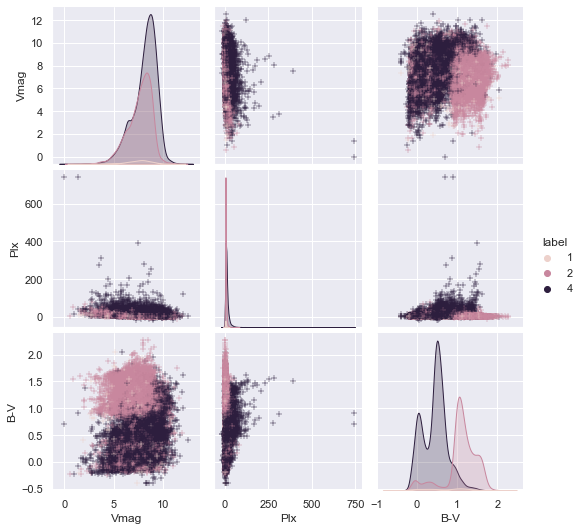

In [24]:
g = sns.pairplot(data_train, hue='label', markers="+")

- from the above plot, one can see that the data is not linearly seperable. Hence, I will not be using linear SVM as one of the classifiers.

### 1.9 Using trained classifiers
- I will be using the SVM classifier, LogisticRegression classifier and RandomForest calssifier.
- The metrics that will be used for comparison are accuracy, presicion, R score and mean squared error(MSE) 

In [25]:
# Create DataFrame to Store Metrics

metrics_on_training = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"],
                                   dtype=float)

metrics_on_test = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"], 
                                   dtype=float)

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Logistic Regression

- Even after using the Quantile Transformer, there still appears to be a few outliers in the data. 

- To resolve this problem and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [26]:
reg=LogisticRegression(C=0.04, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
reg.fit(X_train,y_train)

LogisticRegression(C=0.04)

In [28]:
y_test_pr=np.round(reg.predict(X_test))
y_train_pr=np.round(reg.predict(X_train))

In [29]:
metrics_on_training.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


# Save predicted values to dataframe for later use
y_df["LogReg"] = y_test_pr

metrics_on_test.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier

- Random Forest Classifier was chosen because it contains several decision trees whose aggregate predictions will improve the predictive accuracy of the dataset instead of using a single tree whose performnace will be limited. 

In [30]:
rfc = RandomForestClassifier(criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [32]:
y_test_pr=np.round(rfc.predict(X_test))
y_train_pr=np.round(rfc.predict(X_train))

In [33]:
metrics_on_training.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


# Save predicted values to dataframe for later use
y_df["rfc"] = y_test_pr

metrics_on_test.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- Here, RBF and Poly kernel SVM methods will be used and compared. Linear SVM is not an option because the data is not linearly seperable.

In [34]:
clf_rbf = svm.SVC(kernel='rbf', C=1.0)

In [35]:
clf_rbf.fit(X_train, y_train)

SVC()

In [36]:
y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))

In [37]:
metrics_on_training.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


# Save predicted values to dataframe for later use
y_df["clf_rbf"] = y_test_pr

metrics_on_test.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [38]:
clf_poly = svm.SVC(kernel="poly", degree=2, C=0.01)
clf_poly.fit(X_train, y_train)

SVC(C=0.01, degree=2, kernel='poly')

In [39]:
y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

In [40]:
metrics_on_training.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



# Save predicted values to dataframe for later use
y_df["clf_poly"] = y_test_pr


metrics_on_test.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

<AxesSubplot:>

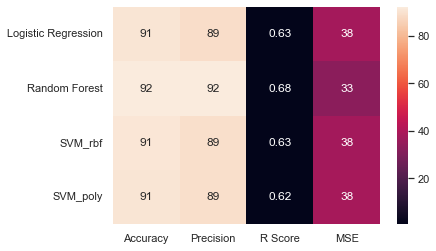

In [41]:
sns.heatmap(data=metrics_on_training, annot=True)

### Test Metrics Heatmap

<AxesSubplot:>

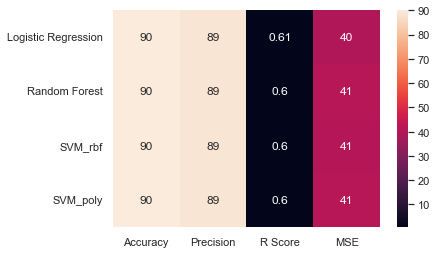

In [42]:
sns.heatmap(data=metrics_on_test, annot=True)

### 1.10 Access and comment on the predictability of the setup

- We observe high MSE scores, due to the highly mixed nature of the dataset. It can be seen from the 3d plots above that the classes are not well distinguished by the three features. This is further outlined by the plot below which shows the average silhouette score (a measure of class separation) in the test and train sets.
- Hence, we resolve to use the RFC model with minimum MSE and highest R-score of all trained models.

In [43]:
skm.silhouette_score(X_train, y_train, metric='euclidean', sample_size=None, random_state=None)

0.1577371816712653

- The average silhoutte score is close to zero which implies that the clusters are overlapping.

#### Clean Exam Data

- I used .isnull and .isna to check if there are any missing values in the data given.

In [44]:
exam_data = pd.read_csv("exam_question.csv")
exam_data = exam_data[["Vmag", "Plx", "B-V"]]

In [45]:
print("Missing values")
print(exam_data.isnull().sum())
print("\n")
print("Missing values")
print(exam_data.isna().sum())

Missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


Missing values
Vmag    0
Plx     0
B-V     0
dtype: int64


- From the results above, it doesn't appear like there are any missing values. However, physically examining at the data, I noticed that there were numerous missing values. So, I try to convert each feature to numeric values and use the error paramter to parse invalid data as NaN

In [46]:
exam_data["Vmag"] = pd.to_numeric(exam_data["Vmag"], downcast="float", errors='coerce')
exam_data["Plx"] = pd.to_numeric(exam_data["Plx"], downcast="float", errors='coerce')
exam_data["B-V"] = pd.to_numeric(exam_data["B-V"], downcast="float", errors='coerce')

- we check again for missing values.

In [47]:
print("Missing values")
print(exam_data.isnull().sum())
print("\n")
print("Missing values")
print(exam_data.isna().sum())

Missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


Missing values
Vmag    0
Plx     2
B-V     1
dtype: int64


- To fix this missing data, we choose to use the Iterative Imputer since it is more ideal becasue it linear regresses the training data. Simple Imputer does not allow flexibility of the imputing strategy, hence the reason for not choosing it.

In [48]:
X_raw = data_train[["Vmag", "Plx", "B-V"]]

imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(X_raw)

X_exam = imp.transform(exam_data)

exam_data[["Vmag", "Plx", "B-V"]] = X_exam

### 1.11 Predict Exam Data

- Now that the data has been successfully cleaned, I will run RFC to predict the encoded Luminousity Classes of the exam question data.

- But I have to first transform the features of the exam data with Quantile Transformer. Then, I will use the inverse transform method of the Label Encoder, already fitted to the raw training data, to extract the Lunminousity Class on the I - VII scale. The file is saved as exam_question_with_predictions.

In [49]:
X_exam = quantile_scaler.transform(exam_data)

In [50]:
y_exam = rfc.predict(X_exam)

In [51]:
y_exam = le.inverse_transform(y_exam)

In [52]:
exam_data["Predictions"] = y_exam

In [162]:
exam_data.to_csv("question1_with_predictions.csv")

# Question 2

## Giants and Dwarfs
- Here, I will label the obeservations with Luminoustity Classes I, II, and III as giant and the rest as dwarf

- Earlier in the dataset, I encoded the luminousity classes from I - VII using LabelEncoder to range from 0 - 6 respectively. I'll do the same for giants(0) and dwarf (1) in a new column called ClassType

In [54]:
# Label Stars with "luminousity Classes" of "I, II, III" as Giant === 0
data_train.loc[(data_train["Luminousity Classes"] == "I") | (data_train["Luminousity Classes"] == "II") | 
               (data_train["Luminousity Classes"] == "III"), 
               "ClassType"] = 0

In [55]:
# Label Stars with "luminousity Classes" of "IV, V, VI, VII"  as Dwarf === 1
data_train.loc[(data_train["Luminousity Classes"] == "IV") | (data_train["Luminousity Classes"] == "V") |
               (data_train["Luminousity Classes"] == "VI") | (data_train["Luminousity Classes"] == "VII")
               , "ClassType"] = 1

In [56]:
data_train.head()

,Vmag,Plx,B-V,SpType,Luminousity Classes,label,ClassType
1,9.27,21.90,0.999,K3V,V,4,1.0
3,8.06,7.75,0.370,F0V,V,4,1.0
4,8.55,2.87,0.902,G8III,III,2,0.0
7,8.59,10.76,0.489,F6V,V,4,1.0
9,8.43,4.06,1.484,K4III,III,2,0.0


In [57]:
X = data_train[["Vmag", "Plx", "B-V"]]
y = data_train["ClassType"]

In [58]:
# split the dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=9)

In [59]:
# visualize the dataset as a 3D plot seperately just to have an idea of how the data is distributed
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-45, descripti…

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

- The data doesn't look well defined so I will transform it using the Quantile transformer on the training set

In [60]:
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

In [61]:
# Now that it has been transformed, I will visualize the data again
interact(plot_3D(X_train, y_train, elevation=10, azimth=-45))

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-45, descripti…

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

- comparing the two plots above, it is evident that the latter plot looks better.
- I will also visualize the test set. 

In [62]:
interact(plot_3D(X_test, y_test, elevation=10, azimth=-45))

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-45, descripti…

<function __main__.plot_3D.<locals>.plotter(elev=10, azim=-45)>

### Using trained classifiers
- I will be using the SVM classifier, LogisticRegression classifier, KNN and RandomForest calssifier.
- The metrics that will be used for comparison are accuracy, presicion, R score and mean squared error(MSE) 

In [63]:
metrics_on_training2 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear",
                                          "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

metrics_on_test2 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", 
                                          "SVM_rbf", "SVM_poly", "KNN"], 
                                   dtype=float)

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Support Vector Machine

- Since the data is linearly seperable, I will be using the Linear SVM. I will also use the RBF and Poly kernel methods. 

In [64]:
clf_linear=svm.SVC(kernel='linear',C=1.0)

In [65]:
clf_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [66]:
y_test_pr = np.round(clf_linear.predict(X_test))
y_train_pr = np.round(clf_linear.predict(X_train))


# Save predicted values to dataframe for later use
y_df["LinearSVM"] = y_test_pr

In [67]:
metrics_on_training2.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_linear", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_linear", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_linear", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_linear", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [68]:
clf_poly = svm.SVC(kernel="poly", degree=2, C=0.01)
clf_poly.fit(X_train, y_train)

SVC(C=0.01, degree=2, kernel='poly')

In [69]:
y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

# Save predicted values to dataframe for later use
y_df["POLY_SVM"] = y_test_pr

In [70]:
metrics_on_training2.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test2.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [71]:
clf_rbf = svm.SVC(kernel='rbf',  C=1.0)
clf_rbf.fit(X_train, y_train)

SVC()

In [72]:
y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))


# Save predicted values to dataframe for later use
y_df["RBF_SVM"] = y_test_pr

In [73]:
metrics_on_training2.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Logistic Regression
- Even after using the Quantile Transformer, there still appears to be a few outliers in the data. 

- To resolve this problem and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [74]:
reg = LogisticRegression(C=0.04, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                           max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                           random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
reg.fit(X_train,y_train)

LogisticRegression(C=0.04)

In [76]:
y_test_pr=np.round(reg.predict(X_test))
y_train_pr=np.round(reg.predict(X_train))

# Save predicted values to dataframe for later use
y_df["LogReg"] = y_test_pr

In [77]:
metrics_on_training2.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



metrics_on_test2.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted",
                                                                                 zero_division=0)*100
metrics_on_test2.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier
- Random Forest Classifier was chosen because it contains several decision trees whose aggregate predictions will improve the predictive accuracy of the dataset instead of using a single tree whose performnace will be limited. 

In [78]:
rfc = RandomForestClassifier(criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [80]:
y_test_pr=np.round(rfc.predict(X_test))
y_train_pr=np.round(rfc.predict(X_train))


# Save predicted values to dataframe for later use
y_df["RFC"] = y_test_pr

In [81]:
metrics_on_training2.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test2.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### K-Nearest Neighbors

- KNN is good for binary classification of data, hence the reason for choosing it.

In [82]:
knn=KNeighborsClassifier(n_neighbors=9,p=2,metric='minkowski')

In [83]:
knn.fit(X_train, y_train)

y_test_pr = np.round(knn.predict(X_test))
y_train_pr = np.round(knn.predict(X_train))


# Save predicted values to dataframe for later use
y_df["KNN"] = y_test_pr

In [84]:
metrics_on_training2.loc["KNN", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training2.loc["KNN", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training2.loc["KNN", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training2.loc["KNN", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test2.loc["KNN", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test2.loc["KNN", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test2.loc["KNN", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test2.loc["KNN", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

<AxesSubplot:>

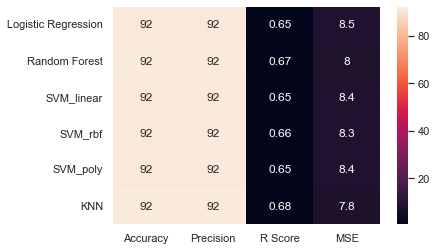

In [85]:
sns.heatmap(data=metrics_on_training2, annot=True)

### Test Metrics Heatmap

<AxesSubplot:>

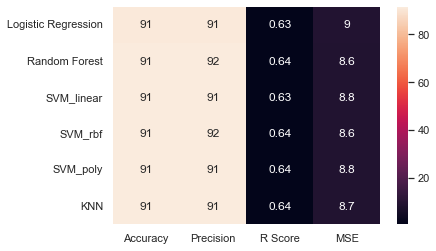

In [86]:
sns.heatmap(data=metrics_on_test2, annot=True)

Text(0.04, 0.5, 'True')

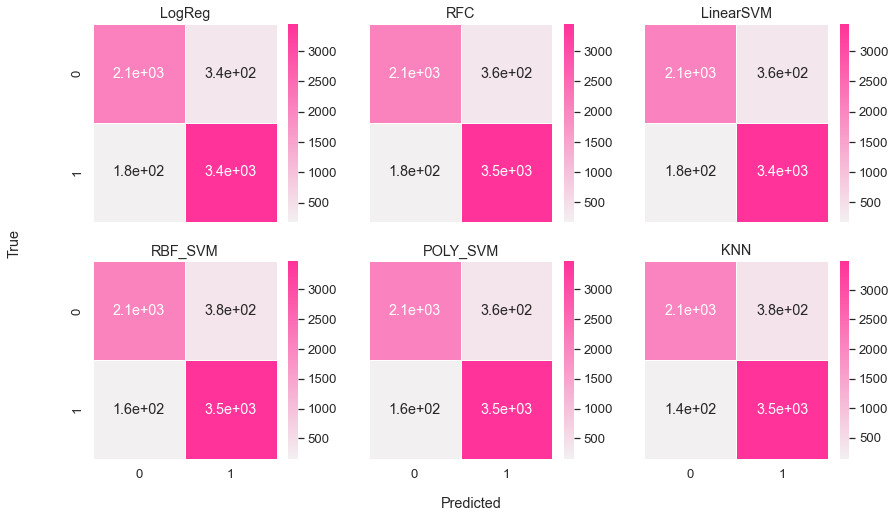

In [87]:
model_list =["LogReg", "RFC", "LinearSVM", "RBF_SVM", "POLY_SVM", "KNN"]

cm = {}

for key in model_list:
    cm[key] = confusion_matrix(y_test, y_df[key], labels=[0, 1])
    cm[key] = pd.DataFrame(cm[key], index=[0, 1], columns=[0, 1])

sns.set(font_scale=1.2)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), sharex=True, sharey=True)

sns.heatmap(cm["LogReg"], ax=axs[0, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RFC"], ax=axs[1, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LinearSVM"], ax=axs[0, 1],  linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RBF_SVM"], ax=axs[1, 1], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["POLY_SVM"], ax=axs[1, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["KNN"], ax=axs[0, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)


axs[0, 0].set_title("LogReg")
axs[0, 1].set_title("RFC")
axs[0, 2].set_title("LinearSVM")
axs[1, 0].set_title("RBF_SVM")
axs[1, 1].set_title("POLY_SVM")
axs[1, 2].set_title("KNN")


fig.text(0.5, 0.04, 'Predicted', ha='center')
fig.text(0.04, 0.5, 'True', va='center', rotation='vertical')

### Comments

- Since all the models have approximately equal metrics, I decided to do a confusion matrix to know which one worked best.
- I used RFC because it has the highest precision, R-score and the lowest MSE.

## Predict Exam Data

- Earlier the data has already been cleaned and transformed so there will be no point repeating that.
- Now, I will run the RFC to predict the encoded dwarf and giant classes of the exam data. I also extracted the star classes in a string format with ClassType 0 representing the Giants and ClassType 1 representing the Dwarfs.
- The file is then saved as question2_with_predictions.

In [88]:
y_exam = rfc.predict(X_exam)

In [89]:
exam_data["Q2_predictions"] = y_exam

In [90]:
exam_data.loc[exam_data["Q2_predictions"] == 0, "Name_Q2"] = "Giant"
exam_data.loc[exam_data["Q2_predictions"] == 1, "Name_Q2"] = "Dwarf"

In [91]:
exam_data.to_csv("question2_with_predictions.csv")

# Question Three

In [92]:
data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(data_train["Plx"]) + 1.0)

- I kept getting this error "Input contains NaN, infinity or a value too large for dtype('float64').", so I suspected that there were observations with P_{lx} of zero or negative 
- So to resolve the error, I took the absolute value of P_{lx}

In [93]:
data_train = data_train[data_train["Plx"] != 0]

data_train["Amag"] = data_train["Vmag"] + 5.0*(np.log10(abs(data_train["Plx"])) + 1)

In [94]:
X = data_train[["B-V", "Amag"]]
y = data_train["label"]

- There are several outliers in the data so MinMaxScaler and absolute MinMaxScaler won't give the desired uniform distribution.
- Instead, I used Quantile Trannsformer to get the desired uniform distribution.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

In [96]:
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

### Using trained classifiers
- I will be using the SVM classifier, LogisticRegression classifier and RandomForest classifier.
- The metrics that will be used for comparison are accuracy, presicion, R score and mean squared error(MSE) 

In [97]:
# Create DataFrame to Store Metrics

metrics_on_training3 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"],
                                   dtype=float)

metrics_on_test3 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_rbf", "SVM_poly"], 
                                   dtype=float)

#### Logistic Regression

- Despite using the QuantileTransformer, there still appears to be a few outliers in the data. 

- To penalize these outliers and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [98]:
reg=LogisticRegression(C=0.04, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [99]:
reg.fit(X_train,y_train)

LogisticRegression(C=0.04)

In [100]:
y_test_pr=np.round(reg.predict(X_test))
y_train_pr=np.round(reg.predict(X_train))

In [101]:
metrics_on_training3.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100



metrics_on_test3.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted",
                                                                                 zero_division=0)*100
metrics_on_test3.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Support Vector Machine

- Since the data isn't linearly seperable, I will not be using the Linear SVM. I will only use the RBF and Poly kernel methods. 

In [102]:
clf_poly = svm.SVC(kernel="poly", degree=2, C=0.01)
clf_poly.fit(X_train, y_train)

SVC(C=0.01, degree=2, kernel='poly')

In [103]:
y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

In [104]:
metrics_on_training3.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test3.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [105]:
clf_rbf = svm.SVC(kernel='rbf',  C=1.0)
clf_rbf.fit(X_train, y_train)

SVC()

In [106]:
y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))

In [107]:
metrics_on_training3.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test3.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier
- Random Forest Classifier was chosen because it contains several decision trees whose aggregate predictions will improve the predictive accuracy of the dataset instead of using a single tree whose performnace will be limited. 

In [108]:
rfc = RandomForestClassifier(criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [109]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [110]:
y_test_pr = np.round(rfc.predict(X_test))
y_train_pr = np.round(rfc.predict(X_train))

In [111]:
metrics_on_training3.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training3.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training3.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training3.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test3.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test3.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test3.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test3.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

<AxesSubplot:>

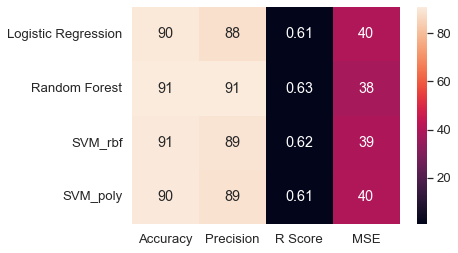

In [112]:
sns.heatmap(data=metrics_on_training3, annot=True)

### Test Metrics Heatmap

<AxesSubplot:>

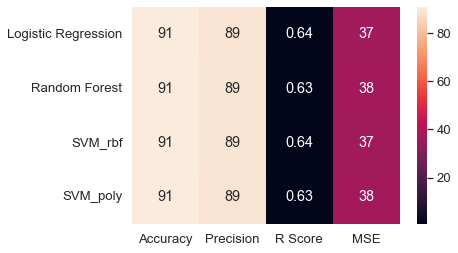

In [113]:
sns.heatmap(data=metrics_on_test3, annot=True)

- From the results above, we see that all the models give approximately the same metrics. The reason for the  high MSE scores is due to the highly mixed nature of the dataset.There are inbalanced classes within the dataset.

### Predict Exam Data

- Here, I will use RFC to predict the encoded Luminousity Classes of the exam question data.

- But I have to first transform the features of the exam data with Quantile Transformer. Then, I will use the inverse transform method of the Label Encoder, already fitted to the raw training data, to extract the Lunminousity Class on the I - VII scale. The file is saved as question3_with_predictions. 

In [114]:
exam_data["Amag"] = exam_data["Vmag"] + 5.0*(np.log10(abs(exam_data["Plx"])) + 1)

In [115]:
X_exam = quantile_scaler.transform(exam_data[["B-V", "Amag"]])

In [116]:
y_exam = rfc.predict(X_exam)

In [117]:
y_exam = le.inverse_transform(y_exam)

In [118]:
exam_data["Prediction3"] = y_exam

In [119]:
exam_data.to_csv("question3_with_predictions.csv")

### Decision Region

- I plotted the decision region with transformed features from the quantile Transformer of both the training and exam data.
- I also encoded the y_labels just like I did earlier using Label Encoder.
-  I only plotted 5% of the training data (since the training set is too large) and to help visualize the data well on the decision boundary.

In [120]:
def decision_region(plot,x,y,classifier,Polynomial=None,resolution=0.02,
                    labels=None,xlabel=None,ylabel=None,
                   test_idx=[]):
    
    plt.figure(figsize=(6,6))
    markers=('s','x','o','+','^','v')
    colors=('red','lightgreen','blue','yellow','magenta','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = x[:,0].min()-0.2, x[:,0].max()+0.2
    x2_min, x2_max = x[:,1].min()-0.2, x[:,1].max()+0.2
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    if Polynomial is None:
        xx=np.array([xx1.ravel(),xx2.ravel()]).T
    else:
        xx=Polynomial.fit_transform(np.array([xx1.ravel(),xx2.ravel()]).T)
    
    z=classifier.predict(xx)
    z=z.reshape(xx1.shape)
    
    plot.xlim(xx1.min(),xx1.max())
    plot.ylim(xx2.min(),xx2.max())
    plot.contourf(xx1,xx2,z,alpha=0.1,cmap=cmap)
    
    if xlabel is not None:
        plot.xlabel(xlabel)
    if ylabel is not None:
        plot.ylabel(ylabel)
    
    for idx, c1 in enumerate(np.unique(y)):
        if labels is not None:
            l1 = labels[c1]
        else:
            l1=c1
        plot.scatter(x[y==c1,0],x[y==c1,1],alpha=0.8,
                    c=colors[idx], marker=markers[idx],label=l1,
                    edgecolor='black')
    
    if len(test_idx) > 0:
        X_test, y_test = x[test_idx, :], y[test_idx]
        plot.scatter(X_test[:, 0], X_test[:, 1],
        c='black',edgecolor='black', alpha=0.1,
        linewidth=1, marker='o', s=100, label='test set')

    plot.legend(loc='upper left')
    plot.show()

In [121]:
le = LabelEncoder()
scaler = QuantileTransformer()

X_train_decision = scaler.fit_transform(data_train[["B-V", "Amag"]])
y_train_decision = le.fit_transform(data_train["Luminousity Classes"])


X_exam_decision = scaler.transform(exam_data[["B-V", "Amag"]])
y_exam_decision = le.transform(exam_data["Prediction3"])



In [122]:
percentage = 5
X_train_decision, X_test_decision, y_train_decision, y_test_decision = train_test_split(X_train_decision, 
                                                                                        y_train_decision, 
                                                                    test_size=percentage/100, random_state=9)

X_all = np.concatenate((X_test_decision, X_exam_decision), axis=0)
y_all = np.concatenate((y_test_decision, y_exam_decision), axis=0)

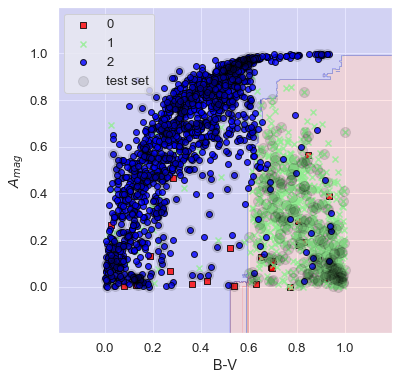

In [123]:
decision_region(plt, X_all, y_all, rfc, Polynomial=None, resolution=0.002,
                labels=None, xlabel="B-V", ylabel='$A_{mag}$', 
                test_idx=np.arange(len(X_test_decision), len(X_all), 1))

# Question Four

In [124]:
X = data_train[["B-V", "Amag"]]
y = data_train["ClassType"]

In [125]:
X_exam = exam_data[["B-V", "Amag"]]

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2, random_state=9)

In [127]:
quantile_scaler = QuantileTransformer()
X_train = quantile_scaler.fit_transform(X_train)
X_test = quantile_scaler.transform(X_test)

### Using trained classifiers
- I will be using the SVM classifier, LogisticRegression classifier, KNN and RandomForest classifier.
- The metrics that will be used for comparison are accuracy, presicion, R score and mean squared error(MSE) 

In [128]:
# Create DataFrame to Store Metrics

metrics_on_training4 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

metrics_on_test4 = pd.DataFrame(columns=["Accuracy", "Precision", "R Score", "MSE"], 
                                   index=["Logistic Regression", "Random Forest", "SVM_linear", "SVM_rbf", "SVM_poly", "KNN"],
                                   dtype=float)

# Save predicted y_values and y_test to dataframe for later use

y_df = pd.DataFrame(y_test, columns=["y_test"])

#### Support Vector Machine

- Since the data is linearly seperable, I will be using the Linear SVM. I will also use the RBF and Poly kernel methods. 

In [129]:
clf_linear=svm.SVC(kernel='linear',C=1.0)

In [130]:
clf_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [131]:
y_test_pr = np.round(clf_linear.predict(X_test))
y_train_pr = np.round(clf_linear.predict(X_train))


# Save predicted values to dataframe for later use
y_df["LinearSVM"] = y_test_pr

In [132]:
metrics_on_training4.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_linear", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_linear", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["SVM_linear", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_linear", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_linear", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_linear", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [133]:
clf_poly = svm.SVC(kernel="poly", degree=2, C=0.01)
clf_poly.fit(X_train, y_train)

SVC(C=0.01, degree=2, kernel='poly')

In [134]:
y_test_pr = np.round(clf_poly.predict(X_test))
y_train_pr = np.round(clf_poly.predict(X_train))

# Save predicted values to dataframe for later use
y_df["POLY_SVM"] = y_test_pr

In [135]:
metrics_on_training4.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_poly", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_poly", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test4.loc["SVM_poly", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_poly", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_poly", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_poly", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

In [136]:
clf_rbf = svm.SVC(kernel='rbf',  C=1.0)
clf_rbf.fit(X_train, y_train)

SVC()

In [137]:
y_test_pr = np.round(clf_rbf.predict(X_test))
y_train_pr = np.round(clf_rbf.predict(X_train))


# Save predicted values to dataframe for later use
y_df["RBF_SVM"] = y_test_pr

In [138]:
metrics_on_training4.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["SVM_rbf", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["SVM_rbf", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["SVM_rbf", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["SVM_rbf", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["SVM_rbf", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["SVM_rbf", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Logistic Regression
- Even after using the Quantile Transformer, there still appears to be a few outliers in the data. 

- To resolve this problem and avoid overfitting, the $L_{2}$ Ridge penalty will be used since most features appear to determine a star's Luminousity Class.

In [139]:
reg = LogisticRegression(C=0.04, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [140]:
reg.fit(X_train,y_train)

LogisticRegression(C=0.04)

In [141]:
y_test_pr = np.round(reg.predict(X_test))
y_train_pr = np.round(reg.predict(X_train))

# Save predicted values to dataframe for later use
y_df["LogReg"] = y_test_pr

In [142]:
metrics_on_training4.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["Logistic Regression", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["Logistic Regression", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["Logistic Regression", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["Logistic Regression", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted",
                                                                                 zero_division=0)*100
metrics_on_test4.loc["Logistic Regression", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["Logistic Regression", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### Random Forest Classifier
- Random Forest Classifier was chosen because it contains several decision trees whose aggregate predictions will improve the predictive accuracy of the dataset instead of using a single tree whose performnace will be limited. 

In [143]:
rfc = RandomForestClassifier(criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [144]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [145]:
y_test_pr=np.round(rfc.predict(X_test))
y_train_pr=np.round(rfc.predict(X_train))


# Save predicted values to dataframe for later use
y_df["RFC"] = y_test_pr

In [146]:
metrics_on_training4.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["Random Forest", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["Random Forest", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100


metrics_on_test4.loc["Random Forest", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["Random Forest", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["Random Forest", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["Random Forest", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

#### K-Nearest Neighbors

- KNN is good for binary classification of data, hence the reason for choosing it.

In [147]:
knn=KNeighborsClassifier(n_neighbors=9,p=2,metric='minkowski')

In [148]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [149]:
y_test_pr = np.round(knn.predict(X_test))
y_train_pr = np.round(knn.predict(X_train))


# Save predicted values to dataframe for later use
y_df["KNN"] = y_test_pr

In [150]:
metrics_on_training4.loc["KNN", "Accuracy"] = skm.accuracy_score(y_train, y_train_pr)*100
metrics_on_training4.loc["KNN", "Precision"] = skm.precision_score(y_train, y_train_pr, average="weighted"
                                                                                 , zero_division=0)*100
metrics_on_training4.loc["KNN", "R Score"] = skm.r2_score(y_train, y_train_pr, multioutput="uniform_average")
metrics_on_training4.loc["KNN", "MSE"] =  skm.mean_squared_error(y_train, y_train_pr)*100

metrics_on_test4.loc["KNN", "Accuracy"] = skm.accuracy_score(y_test, y_test_pr)*100
metrics_on_test4.loc["KNN", "Precision"] = skm.precision_score(y_test, y_test_pr, average="weighted", 
                                                                                zero_division=0)*100
metrics_on_test4.loc["KNN", "R Score"] = skm.r2_score(y_test, y_test_pr, multioutput="uniform_average")
metrics_on_test4.loc["KNN", "MSE"] =  skm.mean_squared_error(y_test, y_test_pr)*100

### Training Metrics Heatmap

<AxesSubplot:>

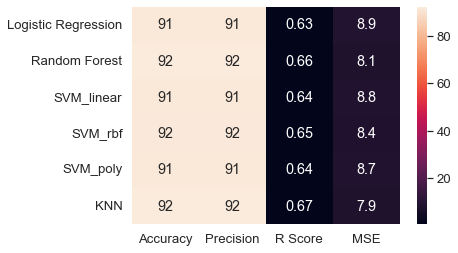

In [151]:
sns.heatmap(data=metrics_on_training4, annot=True)

### Test Metrics Heatmap

<AxesSubplot:>

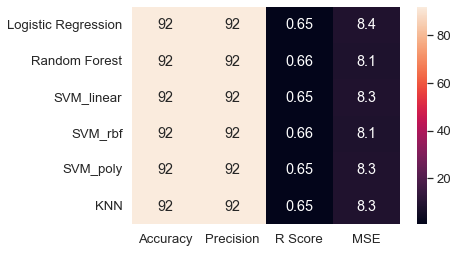

In [152]:
sns.heatmap(data=metrics_on_test4, annot=True)

Text(0.04, 0.5, 'True')

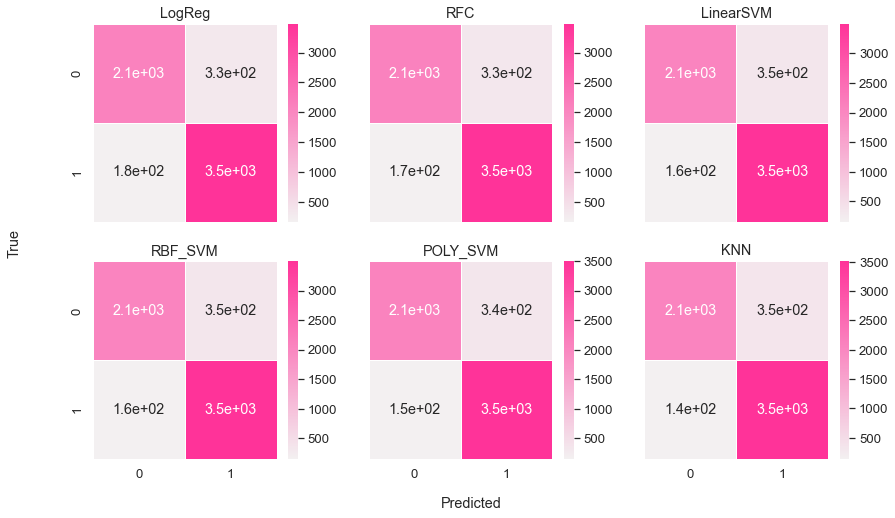

In [153]:
model_list =["LogReg", "RFC", "LinearSVM", "RBF_SVM", "POLY_SVM", "KNN"]

cm = {}

for key in model_list:
    cm[key] = confusion_matrix(y_test, y_df[key], labels=[0, 1])
    cm[key] = pd.DataFrame(cm[key], index=[0, 1], columns=[0, 1])

sns.set(font_scale=1.2)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), sharex=True, sharey=True)

sns.heatmap(cm["LogReg"], ax=axs[0, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RFC"], ax=axs[1, 2], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["LinearSVM"], ax=axs[0, 1],  linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["RBF_SVM"], ax=axs[1, 1], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["POLY_SVM"], ax=axs[1, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
sns.heatmap(cm["KNN"], ax=axs[0, 0], linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)


axs[0, 0].set_title("LogReg")
axs[0, 1].set_title("RFC")
axs[0, 2].set_title("LinearSVM")
axs[1, 0].set_title("RBF_SVM")
axs[1, 1].set_title("POLY_SVM")
axs[1, 2].set_title("KNN")


fig.text(0.5, 0.04, 'Predicted', ha='center')
fig.text(0.04, 0.5, 'True', va='center', rotation='vertical')

### Comments

- Since all the models have approximately equal metrics, I decided to do a confusion matrix to know which one worked best.
- I used RFC because it has the highest precision, R-score and the lowest MSE

## Predict Exam Data

- Earlier the data has already been cleaned so I will transform using Quantile Transformer. 
- Now, I will run the RFC to predict the encoded dwarf and giant classes of the exam data. I also extracted the star classes in a string format with ClassType 0 representing the Giants and ClassType 1 representing the Dwarfs.
- The file is then saved as question4_with_predictions

In [154]:
y_exam = rfc.predict(X_exam)

In [155]:
exam_data["Q4_predictions"] = y_exam

In [156]:
exam_data.loc[exam_data["Q4_predictions"] == 0, "Name_Q4"] = "Giant"
exam_data.loc[exam_data["Q4_predictions"] == 1, "Name_Q4"] = "Dwarf"

In [157]:
exam_data.to_csv("question4_with_predictions.csv")

### Decision Region

- I plotted the decision region with transformed features from the quantile Transformer of both the training and exam data.
- I also encoded the y_labels just like I did earlier using Label Encoder.
- I only plotted 5% of the training data (since the training set is too large) and to help visualize the data well on the decision boundary.

In [158]:
le = LabelEncoder()
scaler = QuantileTransformer()

X_train_decision = scaler.fit_transform(data_train[["B-V", "Amag"]])
y_train_decision = data_train["ClassType"].to_numpy()

X_exam_decision = scaler.transform(exam_data[["B-V", "Amag"]])
y_exam_decision = exam_data["Q4_predictions"].to_numpy()

In [159]:
percentage = 5
X_train_decision, X_test_decision, y_train_decision, y_test_decision = train_test_split(X_train_decision, 
                                                                                        y_train_decision, 
                                                                    test_size=percentage/100, random_state=9)

X_all = np.concatenate((X_test_decision, X_exam_decision), axis=0)
y_all = np.concatenate((y_test_decision, y_exam_decision), axis=0)

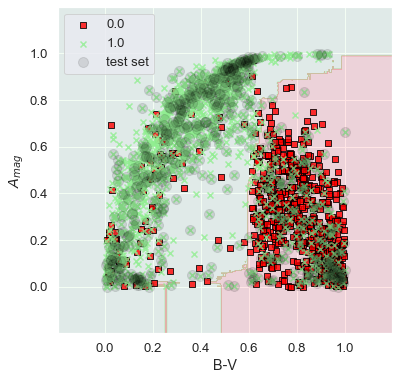

In [160]:

decision_region(plt, X_all, y_all, rfc, Polynomial=None, resolution=0.002,
                labels=None, xlabel="B-V", ylabel='$A_{mag}$', 
                test_idx=np.arange(len(X_test_decision), len(X_all), 1))

### Save Exam Results to File

In [161]:
exam_data.to_csv("solution.csv")